<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Action Recognition (Video Classification) Model

In this notebook, we give an introduction to training an action recognition (video classification) model using torchvision. We demonstrate how to train and evaluate the R(2+1)D model on the [HMDB51](http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/) human action dataset.

## Initialization

Import all the functions we need

In [20]:
import sys
sys.path.append("../../")
import time
import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.cuda as cuda
import torch.nn as nn
import torchvision

from utils_cv.action_recognition.model import VideoLearner 
from utils_cv.action_recognition.dataset import VideoRecord, VideoDataset
from utils_cv.common.gpu import system_info
from utils_cv.common.data import data_path

system_info()

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0] 

PyTorch 1.2.0 

Torch-vision 0.4.0a0 

Available devices:
0: Tesla V100-PCIE-16GB


This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

In [47]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %load_ext blackcellmagic

Next, set some model runtime parameters. Specifiy where you have your HMDB51 dataset downloaded. 

In [9]:
DATA_ROOT = os.path.join(str(data_path()), "misc/hmdb51")
VIDEO_DIR = os.path.join(DATA_ROOT, "videos")

# Number of consecutive frames used as input to the DNN. Recommended: 32 for high accuracy, 8 for inference speed.
MODEL_INPUT_SIZE = 8
# Batch size. Reduce if running out of memory.
BATCH_SIZE = 8
# Number of training epochs
EPOCHS = 1

---

# Prepare Video Detection Dataset

In this notebook, we use the HMDB-51 dataset, which consists of 51 different types of actions.

In [10]:
# This split is known as "split1"
TRAIN_SPLIT = os.path.join(DATA_ROOT, "hmdb51_vid_train_split_1.txt")
TEST_SPLIT = os.path.join(DATA_ROOT, "hmdb51_vid_val_split_1.txt")

In [11]:
data = VideoDataset(
    VIDEO_DIR,
    train_split_file=TRAIN_SPLIT,
    test_split_file=TEST_SPLIT,
    video_ext="avi"
)

<Figure size 432x288 with 0 Axes>

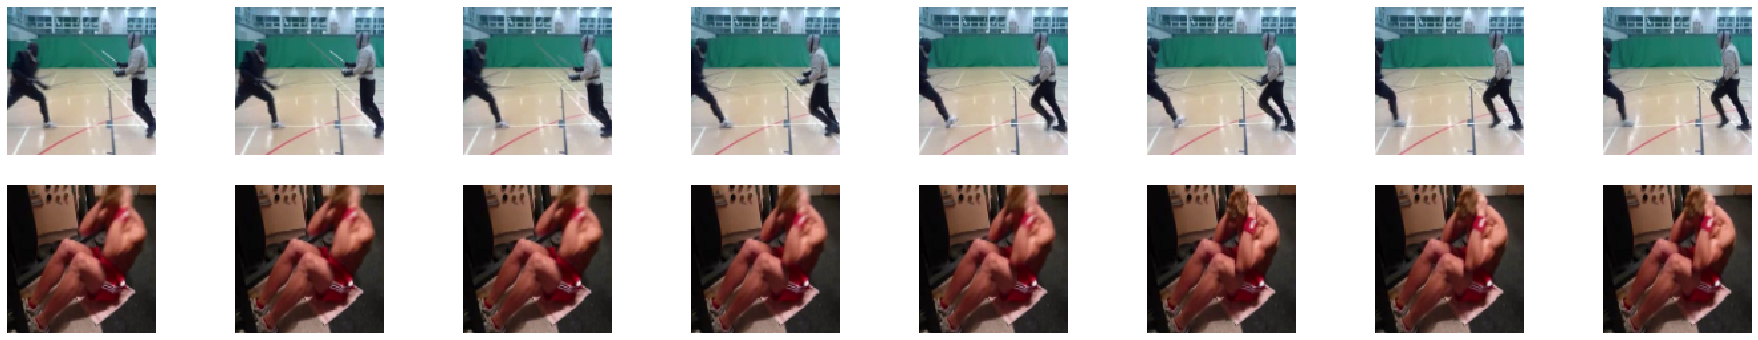

In [18]:
data.show_batch(num_samples=2)

## Setup the Video Learner

In [21]:
learner = VideoLearner(data, num_classes=51)

Loading r2plus1d_34_8_ig65m model


Using cache found in /home/jiata/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


In [25]:
learner.model

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=Tru

In [22]:
learner.dataset.train_ds.dataset.video_records[0].label

13

In [23]:
# Training configuration
train_cfgs = dict(
    epochs=EPOCHS,  # Number of training epochs
    lr=0.0001,  # Learning rate
    lr_step_size=np.ceil(
        2 / 3 * EPOCHS
    ),  # Reduce learning rate by factor of 10 after this many epochs.
    batch_size=BATCH_SIZE,  # Model batch size. Reduce if model cannot fit into memory.
    # No need to change these parameters
    grad_steps=2,  # Accumulate the gradients over multiple forward passes
    mixed_prec=False,  # Use mixed precision to speed up training
)

In [24]:
learner.fit(train_cfgs)

Params to learn:
	full network
Epoch 1 ==========
lr=[0.0001]
train took 213.01 sec: loss = 3.6590, top1_acc = 16.7227, top5_acc = 37.3109
valid took 67.46 sec: loss = 3.1335, top1_acc = 30.8497, top5_acc = 58.7582


Using the paramters below, one can reproduce published results on the HMDB-51 dataset. Video-clip accuracy of close to 80%  can be obtained using as input to the DNN 32 consecutive frames (`MODEL_INPUT_SIZE`) and running 48 training epochs. Even using only 8 epochs the accuracy already reaches 75%. Inference and training speed can be reduced by a factor of 3-4 by setting `MODEL_INPUT_SIZE=8` and using higher batch size, however at a significant loss in accuracy.

## Model Test

Reported accuracy from "Closer look" paper: 74.5% (clip accuracy of 66.1% on split1 based on VMZ repo)

1. sample 10 clips uniformly sampled from each test video: [10 x 3 x (8 or 32) x 112 x 112]
2. calculate clip-level accuracy: Use 10 batch and infer
3. calculate video-level accuracy by averaging them
4. average over the clips

In [ ]:
# ### Load Saved Weights if needed
#learn.load(body_train_cfgs['model_name'] + "_032", body_train_cfgs['model_dir'])

In [26]:
%%black
if cuda.is_available():
    device = torch.device("cuda")
    num_gpus = cuda.device_count()
    # Look for the optimal set of algorithms to use in cudnn. Use this only with fixed-size inputs.
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
    num_gpus = 0

In [38]:
learner.dataset.test_ds.dataset.num_segments = 10

In [ ]:
print(
    f"{len(learner.dataset.test_ds)} samples of {learner.dataset.test_ds[0][0][0].shape}"
)

In [ ]:
# Initialize the model
model = learner.model
model.to(device)
if num_gpus > 1:
    model = nn.DataParallel(model)
model.eval()

# Loop over all examples in the test set and compute accuracies
infer_times = []
video_preds = []
video_trues = []
clip_preds = []
clip_trues = []
report_every = 100

with torch.no_grad():
    for i in range(
        1, len(learner.dataset.test_ds)
    ):  # [::10]:  # Skip some examples to speed up accuracy computation
        if i % report_every == 0:
            print(
                "Processsing {} of {} samples..".format(i, len(learner.dataset.test_ds))
            )

        # Get model inputs
        inputs, label = learner.dataset.test_ds[i]
        inputs = inputs.to(device, non_blocking=True)

        # Run inference
        start_time = time.time()
        outputs = model(inputs)
        outputs = outputs.cpu().numpy()
        infer_time = time.time() - start_time
        infer_times.append(infer_time)

        # Store results
        video_preds.append(outputs.sum(axis=0).argmax())
        video_trues.append(label)
        clip_preds.extend(outputs.argmax(axis=1))
        clip_trues.extend([label] * num_segments)

print(
    "Avg. inference time per video (10 clips) =",
    np.array(infer_times).mean() * 1000,
    "ms",
)
print("Video prediction accuracy =", accuracy_score(video_trues, video_preds))
print("Clip prediction accuracy =", accuracy_score(clip_trues, clip_preds))